In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import necessary library

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Load data from drive

In [ ]:
# Load data
headers = ['comment','is_hate_speech']
data = pd.read_csv('/content/drive/My Drive/Computational Thinking/Data_crawl/data.csv', names=headers)
# Load validation data
headers_vali = ['comment','is_hate_speech', '0', '1', '2', '3', '4', '5', '6', '7', '8']
data_validation = pd.read_csv('/content/drive/My Drive/Computational Thinking/Validation_data/Validation.csv', names = headers_vali)
del data_validation['0']
del data_validation['1']
del data_validation['2']
del data_validation['3']
del data_validation['4']
del data_validation['5']
del data_validation['6']
del data_validation['7']
del data_validation['8']

data_validation.head()
data.head(10)

,comment,is_hate_speech
0,Em đang xả với 1xx+freship ai qtam ib em nhé,0
1,"1 số đặt đc lần nhiều đơn hả mọi người, tưởng ...",0
2,Ác quá🙄,0
3,Ác thật 😔,0
4,Ác vl,1
5,ad cứ để số đt ra ko cần che. Cho nó hết dùng ...,0
6,Ae chánh ta,0
7,Anh Chun có phải trò này mày chuyên làm ko hả ?,0
8,Anh Nguyen mượn đt làm vài đơn Now,0
9,"Bắt đc cho nó ăn hết số đồ nó đặt, nôn ra thì...",0


In [ ]:
# Edit validation data
data_validation = data_validation.dropna(axis=0) # Remove blank lines (Contains NaN)
data_validation["is_hate_speech"] = data_validation["is_hate_speech"].astype(int) # Convert type of column 'is_hate_speech' from float64 to int64

In [ ]:
print("[INFO] Data")
print(data.info())
print("-------------------------------------------")
print("[INFO] Validation Data")
print(data_validation.info())

[INFO] Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764 entries, 0 to 4763
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment         4764 non-null   object
 1   is_hate_speech  4764 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.6+ KB
None
-------------------------------------------
[INFO] Validation Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 0 to 1101
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment         1102 non-null   object
 1   is_hate_speech  1102 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB
None


In [ ]:
X = data['comment']
Y = data['is_hate_speech']
X

0            Em đang xả với 1xx+freship ai qtam ib em nhé
1       1 số đặt đc lần nhiều đơn hả mọi người, tưởng ...
2                                                 Ác quá🙄
3                                               Ác thật 😔
4                                                  Ác vl 
                              ...                        
4759    Xl rồi ng trong cuộc đã nhận lời thì đã xong.k...
4760              Xl= xạo loz chứ hổng phải "xin lỗi" đâu
4761    Xong gia đình chị mút bánh kem có thấy chột dạ...
4762                     Xui cho ông nào lấy phải con này
4763                                               yêu em
Name: comment, Length: 4764, dtype: object

In [ ]:
X_val = data_validation['comment']
Y_val = data_validation['is_hate_speech']
X_val

0                                Việt Hào Nguyễn  má cừ ẻ
1          kiểu như Thạch Sùng còn thiếu cái mẻ kho ấy mà
2       Thế con trinh nó mặc bằng cái gì. Hay lấy lá c...
3                                  Na than loe ko nói j à
4                    Nếu CTS chịu mặc nathan lee mua liền
                              ...                        
1097                                          Hề thật đấy
1098    Thế hoá ra hai anh này đều đam mê đồ nội y của...
1099                             Mua về ship đến nhà CTS 
1100      Tự tạo trò biết thái vkl vậy...2 hiện tượng hài
1101                       NT đc kèo ngon mà hời quá zậy 
Name: comment, Length: 1102, dtype: object

#Preprocessing data

In [ ]:
# Word segmentation
!pip install pyvi
from pyvi import ViTokenizer
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        #self.set_stopwords()

    def segmentation(self):
        return ViTokenizer.tokenize(self.text)

     |████████████████████████████████| 8.5 MB 14.4 MB/s 
     |████████████████████████████████| 743 kB 36.5 MB/s 


In [ ]:
# Example about word segmentation
cmt = "Nguyễn Quang Hải là cầu thủ bóng đá chuyên nghiệp của đội tuyển Việt Nam!"
print(NLP(text=cmt).segmentation())

Nguyễn_Quang_Hải là cầu_thủ bóng_đá chuyên_nghiệp của đội_tuyển Việt_Nam !


In [ ]:
# Loại bỏ các ký tự đặc biệt
import re, string

def clean_text(cmt):
  if type(cmt) != str:
    return
  else:
    cmt = cmt.lower()
    cmt = re.sub('\[.*?]', '', cmt)
    cmt = re.sub('[%s]' % re.escape(string.punctuation), '', cmt)
    cmt = re.sub('\w*\d\w*', '', cmt)
  return cmt

In [ ]:
# upload stopword
stop_word =  open('/content/drive/MyDrive/Computational Thinking/stop_word.txt')
stop_word = stop_word.readlines()
stop_word = [x.strip() for x in stop_word]
print(len(stop_word))
# The function to delete words is stopword

def del_stopword(cmt):
    cmt_clean = clean_text(cmt)
    if cmt_clean == '':
        return
    cmt_seg = NLP(text = cmt_clean).segmentation()
    cmt_seg = cmt_seg.split()
    cmt_seg_tam = cmt_seg
    for x in cmt_seg_tam:
      if x in stop_word:
        cmt_seg.remove(x)
    return cmt_seg

4171


##Preprocessing data

In [ ]:
n = len(X)
for i in range(n):
    X[i] = del_stopword(X[i])
    X[i] = ' '.join(X[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##Preprocessing validation data

In [ ]:
n_val = len(X_val)
for i in range(n_val):
    X_val[i] = del_stopword(X_val[i])
    X_val[i] = ' '.join(X_val[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#Divide the train test dataset

In [ ]:
# split test:30%, train:70%
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size=0.3, random_state=42)

# initialize TfidfVectorizer
# size of vocab: 50000
# min_df: ignore terms that have a document frequency strictly lower than the given threshold
tf = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)

# transform words to vetor
X_train = tf.fit_transform(X_train.values).toarray()
trainVocab = tf.vocabulary_ 
tf = TfidfVectorizer(vocabulary=trainVocab)
X_test = tf.fit_transform(X_test.values).toarray()
X_val = tf.fit_transform(X_val.values).toarray()
print(trainVocab)

{'le': 1505, 'đa': 3489, 'nhân_cách': 2192, 'hả': 1287, 'đĩ': 3655, 'kiểu': 1420, 'khinh': 1353, 'ngta': 2076, 'hám': 1240, 'gái': 1108, 'đĩ kiểu': 3661, 'kiểu khinh': 1425, 'khinh ngta': 1354, 'ngta hám': 2078, 'hám gái': 1242, 'như': 2206, 'cđ': 687, 'khùng': 1389, 'huyền': 1214, 'mình': 1873, 'cái': 612, 'lòn': 1645, 'mũi': 1890, 'to': 2925, 'thee': 2778, 'mũi to': 1908, 'to thee': 2932, 'tâm': 3058, 'hô': 1266, 'zậy': 3444, 'tâm hô': 3069, 'hô zậy': 1268, 'phương': 2497, 'tao': 2749, 'chấp_nhận': 407, 'những': 2261, 'dơ_bẩn': 908, 'mày': 1841, 'không': 1384, 'phương tao': 2499, 'tao chấp_nhận': 2751, 'chấp_nhận những': 409, 'những dơ_bẩn': 2262, 'dơ_bẩn mày': 910, 'mày không': 1844, 'cúp': 681, 'đi': 3520, 'mệt': 1968, 'loz': 1563, 'nó': 2355, 'sao': 2636, 'tien': 2906, 'khác': 1369, 'ko': 1434, 'đó': 3635, 'dong': 854, 'tiền': 2916, 'suong': 2679, 'mơ': 1924, 'rồi': 2616, 'xong': 3363, 'mẹ': 1963, 'trả_lời': 3011, 'bình_luận': 139, 'trả_lời bình_luận': 3012, 'đừng': 3791, 'ns': 22

# Training và evaluting model

###Model SVC

In [ ]:
print("Evaluating by model SVC...")
model_SVC = LinearSVC()
model_SVC.fit(X_train, Y_train)
Y_pred_val = model_SVC.predict(X_val)
Y_pred_test = model_SVC.predict(X_test)

Evaluating by model SVC...


		Validation



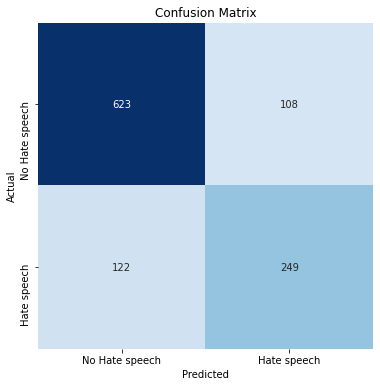



              precision    recall  f1-score   support

           0       0.84      0.85      0.84       731
           1       0.70      0.67      0.68       371

    accuracy                           0.79      1102
   macro avg       0.77      0.76      0.76      1102
weighted avg       0.79      0.79      0.79      1102

		Test



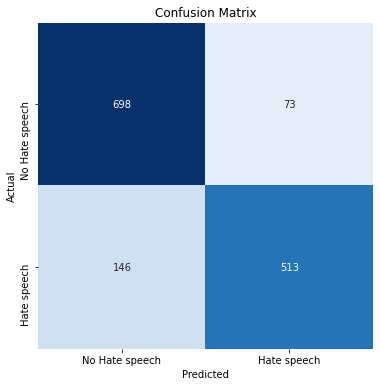



              precision    recall  f1-score   support

           0       0.83      0.91      0.86       771
           1       0.88      0.78      0.82       659

    accuracy                           0.85      1430
   macro avg       0.85      0.84      0.84      1430
weighted avg       0.85      0.85      0.85      1430



In [ ]:
# Build confusion matrix

# Validation data
cm_val = confusion_matrix(Y_val, Y_pred_val, labels = [0, 1])
print("\t\tValidation\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_val,Y_pred_val))

# Test data
cm_test = confusion_matrix(Y_test, Y_pred_test, labels = [0, 1])
print("\t\tTest\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_test,Y_pred_test))

###Model Naive Bayes

In [ ]:
print("Evaluating by model Naive Bayes...")
model_NB = MultinomialNB()

model_NB.fit(X_train, Y_train)
Y_pred_val = model_NB.predict(X_val)
Y_pred_test = model_NB.predict(X_test)

Evaluating by model Naive Bayes...


		Validation



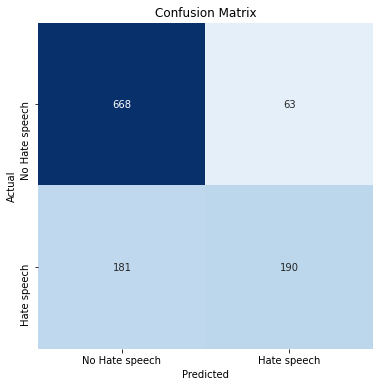



              precision    recall  f1-score   support

           0       0.79      0.91      0.85       731
           1       0.75      0.51      0.61       371

    accuracy                           0.78      1102
   macro avg       0.77      0.71      0.73      1102
weighted avg       0.77      0.78      0.77      1102

		Test



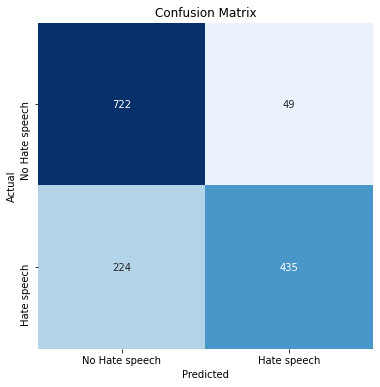



              precision    recall  f1-score   support

           0       0.76      0.94      0.84       771
           1       0.90      0.66      0.76       659

    accuracy                           0.81      1430
   macro avg       0.83      0.80      0.80      1430
weighted avg       0.83      0.81      0.80      1430



In [ ]:
# Build confusion matrix

# Validation data
cm_val = confusion_matrix(Y_val, Y_pred_val, labels = [0, 1])
print("\t\tValidation\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_val,Y_pred_val))

# Test data
cm_test = confusion_matrix(Y_test, Y_pred_test, labels = [0, 1])
print("\t\tTest\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_test,Y_pred_test))

###Model Logistic Regression

In [ ]:
print("Evaluating by model Logistic Regression...")
model_LG = LogisticRegression()

model_LG.fit(X_train, Y_train)
Y_pred_val = model_LG.predict(X_val)
Y_pred_test = model_LG.predict(X_test)

Evaluating by model Logistic Regression...


		Validation



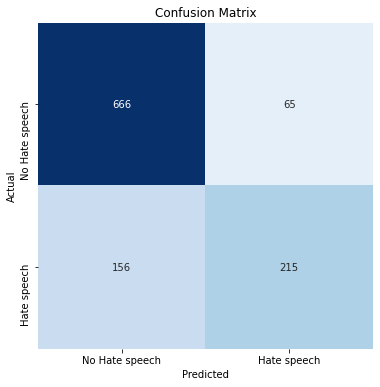



              precision    recall  f1-score   support

           0       0.81      0.91      0.86       731
           1       0.77      0.58      0.66       371

    accuracy                           0.80      1102
   macro avg       0.79      0.75      0.76      1102
weighted avg       0.80      0.80      0.79      1102

		Test



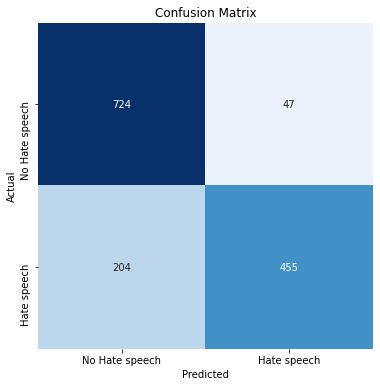



              precision    recall  f1-score   support

           0       0.78      0.94      0.85       771
           1       0.91      0.69      0.78       659

    accuracy                           0.82      1430
   macro avg       0.84      0.81      0.82      1430
weighted avg       0.84      0.82      0.82      1430



In [ ]:
# Build confusion matrix

# Validation data
cm_val = confusion_matrix(Y_val, Y_pred_val, labels = [0, 1])
print("\t\tValidation\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_val,Y_pred_val))

# Test data
cm_test = confusion_matrix(Y_test, Y_pred_test, labels = [0, 1])
print("\t\tTest\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_test,Y_pred_test))

###Model Decision Tree Classifier

In [ ]:
print("Evaluating by model Decision Tree Classifier...")
model_DT = DecisionTreeClassifier()

model_DT.fit(X_train, Y_train)
Y_pred_val = model_DT.predict(X_val)
Y_pred_test = model_DT.predict(X_test)

Evaluating by model Decision Tree Classifier...


		Validation



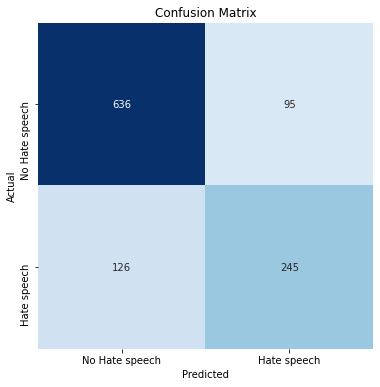



              precision    recall  f1-score   support

           0       0.83      0.87      0.85       731
           1       0.72      0.66      0.69       371

    accuracy                           0.80      1102
   macro avg       0.78      0.77      0.77      1102
weighted avg       0.80      0.80      0.80      1102

		Test



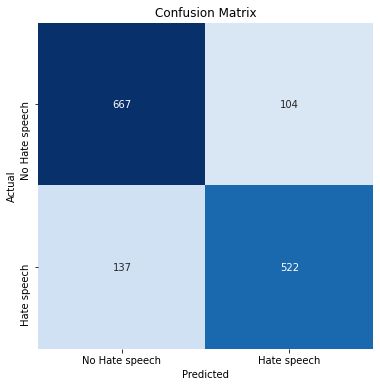



              precision    recall  f1-score   support

           0       0.83      0.87      0.85       771
           1       0.83      0.79      0.81       659

    accuracy                           0.83      1430
   macro avg       0.83      0.83      0.83      1430
weighted avg       0.83      0.83      0.83      1430



In [ ]:
# Build confusion matrix
# Validation data
cm_val = confusion_matrix(Y_val, Y_pred_val, labels = [0, 1])
print("\t\tValidation\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_val,Y_pred_val))

# Test data
cm_test = confusion_matrix(Y_test, Y_pred_test, labels = [0, 1])
print("\t\tTest\n")
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Hate speech", "Hate speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\n")
print(classification_report(Y_test,Y_pred_test))

#Reviews of models:

* Model Decision Tree Classifier and Logistic Regression gives accuracy on the highest validation set (80%)
* Model SVC gives accuracy on the highest test set (85%)

# Dự đoán 1 chuỗi nhập vào có phải là câu thô tục hay không

In [ ]:
text = input("Nhập vào chuỗi bạn muốn: ")

Nhập vào chuỗi bạn muốn: vãi nồi


In [ ]:
def preprocessing(text):
  text_del = del_stopword(text)
  text_del = " ".join(text_del)
  text = tf.fit_transform([text_del])
  return text

In [ ]:
def Predict(text):
  text_pre = preprocessing(text)
  predict = model_SVC.predict(text_pre)

  if predict == 1:
    print("Đây là câu thô tục.")
  else:
    print("Đây không là câu thô tục.")

In [ ]:
Predict(text)

Đây là câu thô tục.
